# Flexible Sunshading in Python

###Author: Patrick Cole (pcole@geoscience.org.za)

Sunshading is a valuable tool for all interpreters of potential field data. Its found in image processing packages and geophysical packages alike. However, it always seems to be limited to only varying the azimuth and elevation of the sun.

It seems that there are far more things that one can tweak with sunshading - providing impressive control over your data. Below is an implementation of the Blinn shader algorithim in the following paper:
    
Horn, B. K. P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE, 69(1), 14–47. doi:10.1109/PROC.1981.11918

Before I get to the sunshading part, the following routine is a simple way to eliminate outliers from your data. It can be useful in applying a nice color stretch to the data. Note that I will only be using this on the color image portion of the sunshading, not the shading itself. If you modify the data being shaded in any way, it can cause some wierd artifacts in the shading.

In [1]:
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [2]:
def histcomp(img, nbr_bins=256, perc=5.):
    """ Histogram Compaction """
    tmp = img.compressed()

    imhist, bins = np.histogram(tmp, nbr_bins)

    cdf = imhist.cumsum()  # cumulative distribution function
    cdf = cdf / float(cdf[-1])  # normalize

    perc = perc/100.

    sindx = np.arange(nbr_bins)[cdf > perc][0]
    eindx = np.arange(nbr_bins)[cdf < (1-perc)][-1]+1
    svalue = bins[sindx]
    evalue = bins[eindx]

    scnt = perc*(nbr_bins-1)
    if scnt > sindx:
        scnt = sindx

    ecnt = perc*(nbr_bins-1)
    if ecnt > ((nbr_bins-1)-eindx):
        ecnt = (nbr_bins-1)-eindx

    img2 = np.empty_like(img, dtype=np.float32)
    np.copyto(img2, img)

    filt = np.ma.less(img2, svalue)
    img2[filt] = svalue

    filt = np.ma.greater(img2, evalue)
    img2[filt] = evalue

    return img2

These next three functions are the engine of the sunshading. 'norm2' is just a simple function to normalise data. 'currentshader' is the code that produces the new sunshaded dataset. 'sunshade' is the routine that we call, which brings it all together. Notice that the sunshading result (snorm) is being used to scale the colormap dataset (colormap). 

In [3]:
def sunshade(data, azim=-np.pi/4., elev=np.pi/4., alpha=1, cell=100):
    #   data: input MxN data to be imaged
    #   alpha: how much incident light is reflected (0 to 1)
    #   phi: azimuth
    #   theta: sun elevation
    #   cell: between 1 and 100 - controls sunshade detail. 
    
    mask = data.mask
    
    sunshader = currentshader(data, cell, elev, azim, alpha)
    snorm = norm2(sunshader)
    pnorm = np.uint8(norm2(histcomp(data))*255)
    #pnorm = uint8(norm2(data)*255)

    colormap = cm.terrain(pnorm)
    colormap[:,:,0] = colormap[:,:,0]*snorm
    colormap[:,:,1] = colormap[:,:,1]*snorm
    colormap[:,:,2] = colormap[:,:,2]*snorm
    colormap[:,:,3] = np.logical_not(mask)
    
    return colormap

def norm2(dat):
    # Normalise vector
    datmin = np.min(dat)
    datmax = np.max(dat)
    return (dat-datmin)/(datmax-datmin)

def currentshader(data, cell, theta, phi, alpha):
# Blinn shader
#     alpha: how much incident light is reflected
#     n: how compact the bright patch is
#     phi: azimuth
#     theta: sun elevation (also called g in code below)

    cdy = np.array([[1., 2., 1.], [0., 0., 0.], [-1., -2., -1.]])
    cdx = np.array([[1., 0., -1.], [2., 0., -2.], [1., 0., -1.]])

    dzdx = ndimage.convolve(data, cdx)  # Use convolve: matrix filtering
    dzdy = ndimage.convolve(data, cdy)  # 'valid' gets reduced array

    dzdx = dzdx/8.
    dzdy = dzdy/8.

    pinit = dzdx
    qinit = dzdy

# Update cell
    p = pinit/cell
    q = qinit/cell
    sqrt_1p2q2 = np.sqrt(1+p**2+q**2)

# Update angle
    cosg2 = np.cos(theta/2)
    p0 = -np.cos(phi)*np.tan(theta)
    q0 = -np.sin(phi)*np.tan(theta)
    sqrttmp = (1+np.sqrt(1+p0**2+q0**2))
    p1 = p0 / sqrttmp
    q1 = q0 / sqrttmp

    n = 2.0

    cosi = ((1+p0*p+q0*q)/(sqrt_1p2q2*np.sqrt(1+p0**2+q0**2)))
    coss = ((1+p1*p+q1*q)/(sqrt_1p2q2*np.sqrt(1+p1**2+q1**2)))
    Ps = coss**n
    R = ((1-alpha)+alpha*Ps)*cosi/cosg2
    return R

Okay, now I am ready to test. First load in a simple dataset. This is a DTM of an area in South Africa. It does have nodata values, so I will mask those.

In [4]:
data=np.loadtxt('dtm.asc', skiprows=6)
data = np.ma.masked_equal(data, 1e+20)

Now we can sunshade. I have chosen the alpha and cell values to be 1 and 5 respectively in this case. Alpha ranges between 0 and 1. Cell ranges between 1 and 100. 

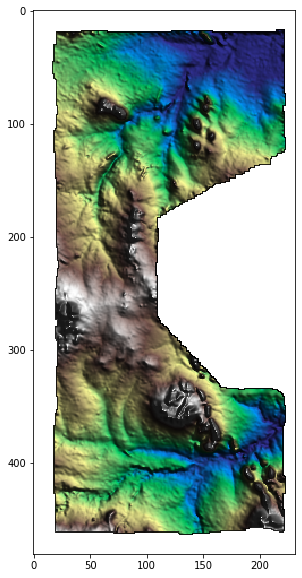

In [5]:
sdata = sunshade(data, alpha=1, cell=5)
plt.figure(figsize= (8,10))
plt.imshow(sdata);

Now using alpha at .5

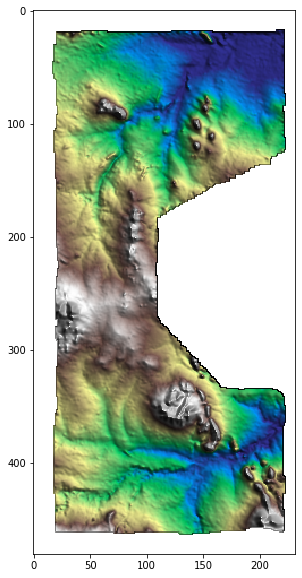

In [6]:
sdata = sunshade(data, alpha=.5, cell=5)
plt.figure(figsize= (8,10))
plt.imshow(sdata);

And finally alpha at 0 and cell at 100

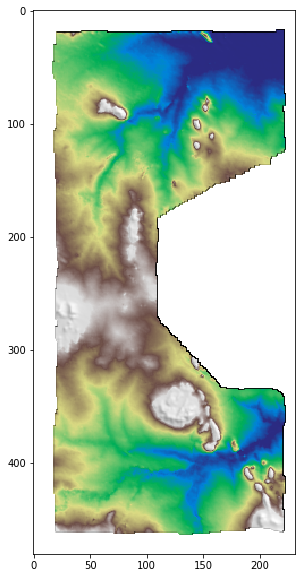

In [7]:
sdata = sunshade(data, alpha=0, cell=100)
plt.figure(figsize= (8,10))
plt.imshow(sdata);